In [1]:
%load_ext autoreload
%autoreload 2

## Intro


In this notebook, I will take ideas from the transformed_outcome_tree.iypnb and try_shap_fork.ipynb to demonstrate the use of shap for 

a) the decomposition of CATE predictions

and 

b) the decomposition of predicted hetereogeneity (deviation from the average treatment effect)

on simulation data.

I will first demonstrate the general idea and use of code on a **transformed outcome tree** (adaptive, since honest estimation is not yet implemented in scikit-learn, I might get on that soon if I have time), and then move to the **GRF** implementation from econML.


## Heterogeneous treatment effects

### PNAS simulation (2016)

I use a simulation setting by Athey & Imbens: we have a model $\eta(x)$ for the mean effect and a model $\kappa(x)$ for the treatment effect. Here I replicate the first of the three settings from the paper.


**Setting**
- K = 2
- $\eta(x) = \frac{1}{2}x_1 + x_2$
- $\kappa(x) = \frac{1}{2}x_1$
- w fully randomized

**Data generating process**
- $Y_i(w) = \eta(X_i) + \frac{1}{2}(2w-1) \kappa(X_i) + \epsilon_i$

where $\epsilon_i \sim N(0,0.01)$ and the Xs are independent $X_i \sim N(0,1)$.

**Summary**

Thus, we can write the DGP as follows:
$$Y_i(w) = \frac{1}{2}x_1 + x_2 + \frac{1}{2}(2w-1) \frac{1}{2}x_1 + \epsilon_i$$

Just for completeness, the CATE is then of course given by:
$$\tau(x) = E(Y_i(1) - Y_i(0) | X) = E(Y_i | X, W=1) - E(Y_i | X, W=0) = \frac{1}{2}\kappa(X_i) - -\frac{1}{2}\kappa(X_i) = \kappa(X_i) = \frac{1}{2}x_1$$

### Demonstration

In [24]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# set seed
np.random.seed(2)

# simulating data

def simulate_exp1(n, pr_w = 0.5, var_eps = 0.01):
    # draw both Xs from independent normals
    x1 = np.random.normal(0, 1, n)
    x2 = np.random.normal(0, 1, n)
    # compute random w
    w = np.random.binomial(1, pr_w, n)
    # compute error
    epsilon = np.random.normal(0, var_eps, n)
    # compute outcome
    y = 0.5 * x1 + x2 + 0.5*((2*w)-1)*0.5*x1 + epsilon
    # compute transformed outcome for TOT
    y_transformed = (y*(w-pr_w)) / (pr_w*(1-pr_w))
    # we also compute the true CATE for each observation
    cate = 0.5*x1
    # create dataframe
    df = pd.DataFrame({'x1': x1, 'x2': x2, 'w': w, 'y': y, 'y_transformed': y_transformed, 'cate': cate})
    return df

# simulate data
df_train = simulate_exp1(3000, pr_w=0.5, var_eps=0.01) # as in paper
df_train.head()

,x1,x2,w,y,y_transformed,cate
0,-0.416758,1.441249,1,1.140962,2.281923,-0.208379
1,-0.056267,-0.736630,0,-0.749965,1.499930,-0.028133
2,-2.136196,2.035754,1,0.435708,0.871416,-1.068098
3,1.640271,-2.616927,0,-2.214085,4.428170,0.820135
4,-1.793436,-2.006425,1,-3.366007,-6.732014,-0.896718


#### Transformed outcome trees

Note that these transformed outcome trees are:
- noisy (they do not use the assignment information optimally) (PNAS, 2016)
- adaptive (they do not satisfy the "honest" requirement for a better MSE and correct inferential properties) (JASA, 2018)

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


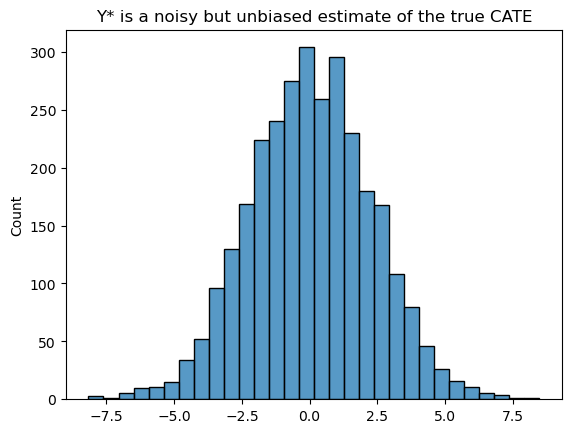

In [25]:
# plot difference between y_transformed and cate
cate_diff = df_train['y_transformed'] - df_train['cate']
sns.histplot(cate_diff, bins=30)
plt.title('Y* is a noisy but unbiased estimate of the true CATE')
plt.show()

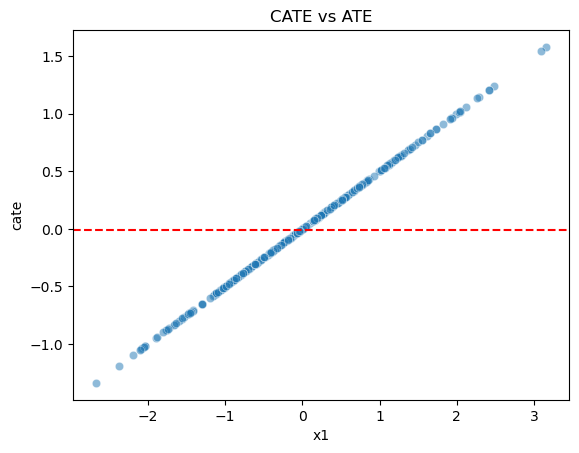

In [26]:
# plot ate and cate across x1
true_ate = df_train['cate'].mean()

plot_df = df_train.sample(300)
sns.scatterplot(x='x1', y='cate', data=plot_df, alpha=0.5)
plt.axhline(true_ate, color='red', linestyle='--')
plt.title('CATE vs ATE')
plt.show()

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# define model
rf = RandomForestRegressor()
X_train = df_train[['x1', 'x2']]
y_train = df_train['y_transformed'] 

# define grid
param_grid = {'n_estimators': [20, 50, 100],
              'max_depth': [2, 3, 5, 10]}

# define grid search
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5)
grid_search.fit(X_train, y_train)

# get best estimator
print(grid_search.best_params_)
best_rf = grid_search.best_estimator_

{'max_depth': 2, 'n_estimators': 100}


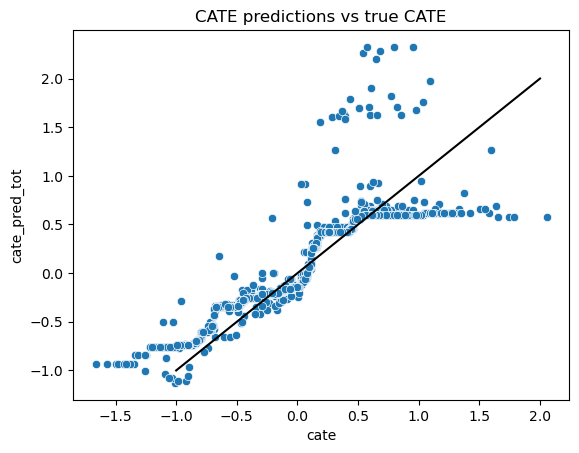

In [28]:
# get cate predictions
df_train['cate_pred_tot'] = best_rf.predict(X_train)

# plot cate predictions against true cate
sns.scatterplot(x='cate', y='cate_pred_tot', data=df_train)
# 45 degree line
plt.plot([-1, 2], [-1, 2], color='black')
plt.title('CATE predictions vs true CATE')
plt.show()

In [88]:
# generate a test set for shap
df_test = simulate_exp1(1000, pr_w=0.5, var_eps=0.01)
X_test = df_test[['x1', 'x2']]

### Applying shap

##### CATE decompositon

In [8]:
from shap.explainers import _tree

init from local version!
imported from folder


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [30]:
tot_tE = _tree.TreeExplainer(best_rf, data = X_test, model_output = "raw", feature_dependence = "interventional")
tot_tE.model.get_transform()

'identity'

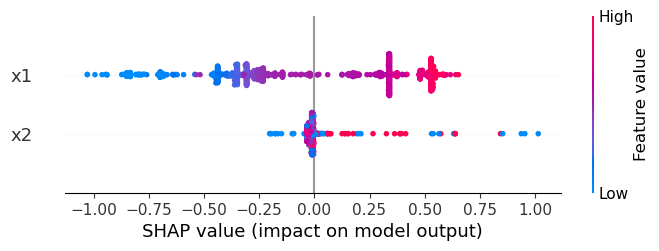

In [31]:
import shap

# get shap values
shap_values = tot_tE(X_test)
shap.plots.beeswarm(shap_values)

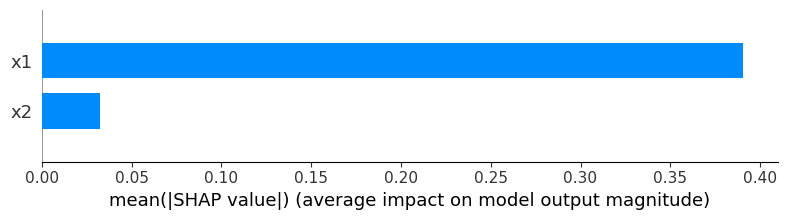

In [32]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

#### Heterogeneity decomposition

In [33]:
tot_tE_het = _tree.TreeExplainer(best_rf, data=df_test, model_output="squared_loss", feature_dependence="interventional")
tot_tE_het.model.get_transform()

'squared_loss'

In [34]:
dev_sv = tot_tE_het(X_test, y = np.array([true_ate]*len(X_test)))

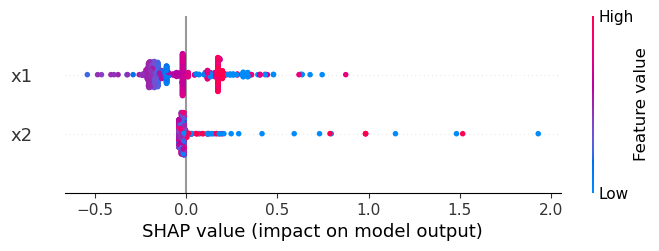

In [35]:
shap.plots.beeswarm(dev_sv)

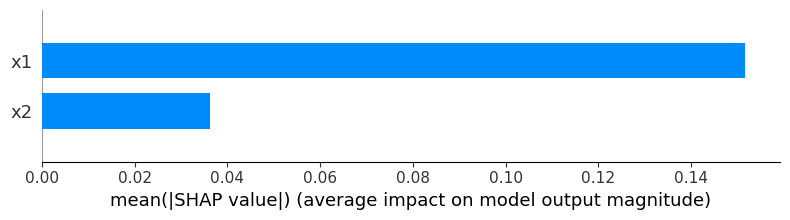

In [36]:
shap.summary_plot(dev_sv, X_test, plot_type="bar")

### Causal Forest

In [40]:
from econml.grf import CausalForest

est = CausalForest()

In [74]:
est.fit(X = X_train, y = df_train["y"], T = df_train['w'])
df_train['cate_pred_cf'] = est.predict(X_train)

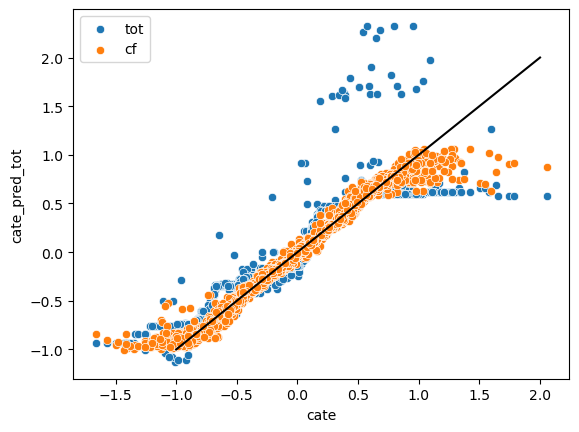

In [75]:
# plot tot predictions
sns.scatterplot(x='cate', y='cate_pred_tot', data=df_train, label='tot')
sns.scatterplot(x='cate', y='cate_pred_cf', data=df_train, label = 'cf')
# 45 degree line
plt.plot([-1, 2], [-1, 2], color='black')
plt.legend()
plt.show()


In [76]:
from econml.dml import CausalForestDML

est_dml = CausalForestDML(discrete_treatment=True)
est_dml.tune(Y = df_train["y"], T = df_train['w'], X = X_train)
est_dml.fit(Y = df_train["y"], T = df_train['w'], X = X_train)


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [77]:
# get cate predictions
df_train['cate_pred_dml'] = est_dml.effect(X_train)

In [78]:
# compare MSEs
mse_tot = np.mean((df_train['cate'] - df_train['cate_pred_tot'])**2)
mse_cf = np.mean((df_train['cate'] - df_train['cate_pred_cf'])**2)
mse_dml = np.mean((df_train['cate'] - df_train['cate_pred_dml'])**2)

print('MSE tot: ', mse_tot)
print('MSE cf: ', mse_cf)
print('MSE dml: ', mse_dml)


MSE tot:  0.045720265320602284
MSE cf:  0.00814638645432806
MSE dml:  0.0007186985770743321


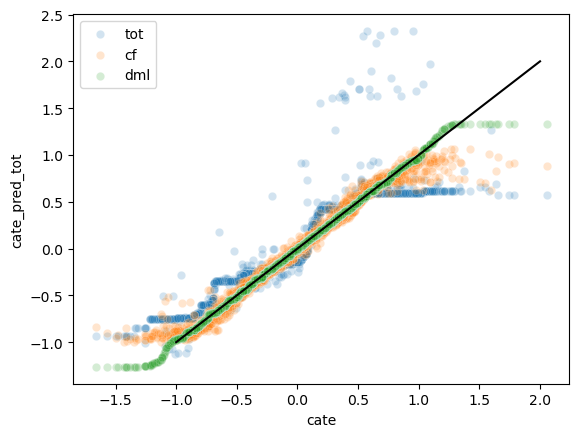

In [79]:
# plot all predictions
sns.scatterplot(x='cate', y='cate_pred_tot', data=df_train, label='tot', alpha = 0.2)
sns.scatterplot(x='cate', y='cate_pred_cf', data=df_train, label = 'cf', alpha = 0.2)
sns.scatterplot(x='cate', y='cate_pred_dml', data=df_train, label = 'dml', alpha = 0.2)
# 45 degree line
plt.plot([-1, 2], [-1, 2], color='black')
plt.legend()
plt.show()

### Applying shap again

In [173]:
import econml
econml.__version__

'0.14.1'

In [129]:
type(est_dml)

econml.dml.causal_forest.CausalForestDML

In [130]:
type(est_dml.model_cate)

econml.grf.classes.MultiOutputGRF

In [132]:
print(len(est_dml.model_cate.estimators_))
type(est_dml.model_cate.estimators_[0])

1


econml.grf.classes.CausalForest

In [133]:
print(len(est_dml.model_cate.estimators_[0].estimators_))
type(est_dml.model_cate.estimators_[0].estimators_[0])

100


econml.grf._base_grftree.GRFTree

In [134]:
cf_tE = _tree.TreeExplainer(est_dml.model_cate.estimators_[0], data = X_test, model_output = "raw", feature_dependence = "interventional")

imported from folder


In [135]:
cf_tE.model.get_transform()

'identity'

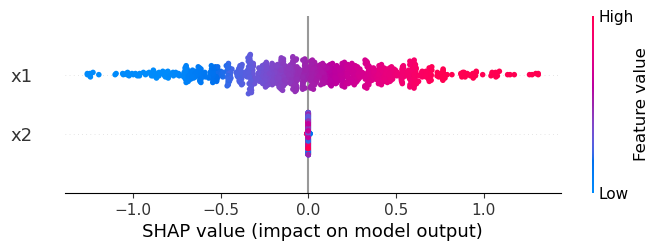

In [136]:
cf_sv = cf_tE(X_test)

shap.plots.beeswarm(cf_sv)

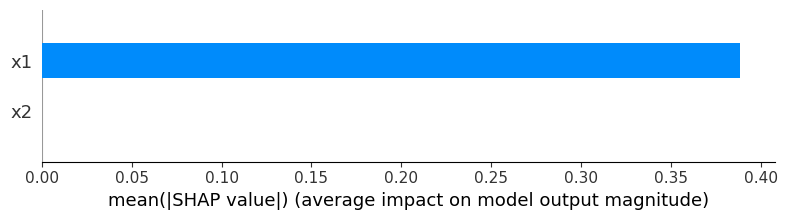

In [137]:
# bar plot
shap.summary_plot(cf_sv, X_test, plot_type="bar")

### More complicated DGP (still experimental)

**Setting**
- K = 5
- Main effect: $\eta(x) = \frac{1}{2}x_1 + x_2 + x_3$
- Treatment effect: $\kappa(x) = \frac{1}{2}x_1 + x_4$
- Randomized treatment assignment: $Pr(W=1) = 0.5$

**Data generating process**
- $Y_i(w) = \eta(X_i) + \frac{1}{2}(2w-1) \kappa(X_i) + \epsilon_i$

where $\epsilon_i \sim N(0,0.01)$ and the Xs are independent $X_i \sim N(0,1)$.

Parameter $x_1$ and $x_4$ are the only covariates that contribute to the treatment effect. $x_5$ is a "noise" parameter that does not contribute to either the main effect or the treatment effect. 

In [138]:
def simulate_exp2(n, pr_w = 0.5, var_eps = 0.01):
    # draw all Xs from independent normals
    x1 = np.random.normal(0, 1, n)
    x2 = np.random.normal(0, 1, n)
    x3 = np.random.normal(0, 1, n)
    x4 = np.random.normal(0, 1, n)
    x5 = np.random.normal(0, 1, n)
    # compute random w
    w = np.random.binomial(1, pr_w, n)
    # compute error
    epsilon = np.random.normal(0, var_eps, n)
    # compute the true CATE for each observation
    cate = (0.5*x1) + x4
    # compute outcome
    y = 0.5 * x1 + x2 + x3 + 0.5*((2*w)-1)*cate + epsilon
    # compute transformed outcome for TOT
    y_transformed = (y*(w-pr_w)) / (pr_w*(1-pr_w))
    # create dataframe
    df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 'x5': x5, 'w': w, 'y': y, 'y_transformed': y_transformed, 'cate': cate})
    return df

df_train = simulate_exp2(3000, pr_w=0.5, var_eps=0.01) 

In [175]:
df_test = simulate_exp2(1000, pr_w=0.5, var_eps=0.01)
X_test = df_test[['x1', 'x2', 'x3', 'x4', 'x5']]

In [139]:
true_ate = df_train['cate'].mean()
true_ate

0.00838352724840405

In [140]:
# define model

rf = RandomForestRegressor()
x_cols = ['x1', 'x2', 'x3', 'x4', 'x5']
X_train = df_train[x_cols] 

# define grid
param_grid = {'n_estimators': [20, 50, 100],
              'max_depth': [2, 3, 5, 10]}

# define grid search
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5)
grid_search.fit(X_train, df_train['y_transformed'])

# get best estimator
print(grid_search.best_params_)
best_rf = grid_search.best_estimator_

{'max_depth': 5, 'n_estimators': 50}


In [141]:
# train causal forest
cf_dml = CausalForestDML(discrete_treatment=True)
cf_dml.tune(Y = df_train["y"], T = df_train['w'], X = X_train)
cf_dml.fit(Y = df_train["y"], T = df_train['w'], X = X_train)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


MSE tot:  0.32434130916645304
MSE cf:  0.014142646467271834


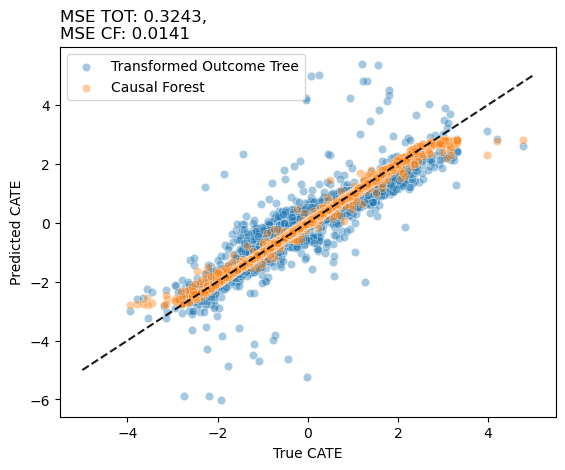

In [168]:
# get predictions
df_train['cate_pred_tot'] = best_rf.predict(X_train)
df_train['cate_pred_cf'] = cf_dml.effect(X_train)

# compare MSEs
mse_tot = np.mean((df_train['cate'] - df_train['cate_pred_tot'])**2)
mse_cf = np.mean((df_train['cate'] - df_train['cate_pred_cf'])**2)

print('MSE tot: ', mse_tot)
print('MSE cf: ', mse_cf)

# plot all predictions
sns.scatterplot(x='cate', y='cate_pred_tot', data=df_train, label='Transformed Outcome Tree', alpha = 0.4)
sns.scatterplot(x='cate', y='cate_pred_cf', data=df_train, label = 'Causal Forest', alpha = 0.4)
# 45 degree line
plt.plot([-5, 5], [-5, 5], color='black', linestyle='--', alpha = 0.9)
plt.legend()

# set title alignment to left
plt.gca().set_title('MSE TOT: ' + str(round(mse_tot, 4)) + ', \nMSE CF: ' + str(round(mse_cf, 4)), loc='left')

plt.ylabel("Predicted CATE")
plt.xlabel("True CATE")
plt.show()

MSE tot:  0.21954781185811645
MSE cf:  0.013399197030746901


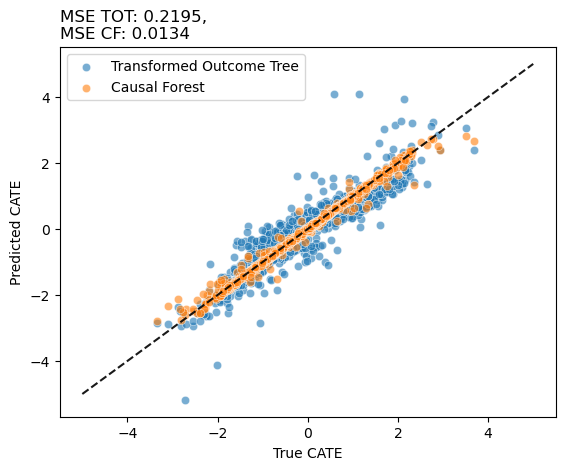

In [177]:
# do the same as above but using test set
df_test['cate_pred_tot'] = best_rf.predict(X_test)
df_test['cate_pred_cf'] = cf_dml.effect(X_test)

# compare MSEs
mse_tot = np.mean((df_test['cate'] - df_test['cate_pred_tot'])**2)
mse_cf = np.mean((df_test['cate'] - df_test['cate_pred_cf'])**2)

print('MSE tot: ', mse_tot)
print('MSE cf: ', mse_cf)

# plot all predictions
sns.scatterplot(x='cate', y='cate_pred_tot', data=df_test, label='Transformed Outcome Tree', alpha = 0.6)
sns.scatterplot(x='cate', y='cate_pred_cf', data=df_test, label = 'Causal Forest', alpha = 0.6)
# 45 degree line
plt.plot([-5, 5], [-5, 5], color='black', linestyle='--', alpha = 0.9)
plt.legend()

# set title alignment to left
plt.gca().set_title('MSE TOT: ' + str(round(mse_tot, 4)) + ', \nMSE CF: ' + str(round(mse_cf, 4)), loc='left')

plt.ylabel("Predicted CATE")
plt.xlabel("True CATE")
plt.show()

In [171]:
import sklearn
sklearn.__version__

'1.2.2'

In [146]:
# compare the shap values
tot_tE = _tree.TreeExplainer(best_rf, data = X_train, model_output = "raw", feature_dependence = "interventional")
tot_sv = tot_tE(X_train)

cf_tE = _tree.TreeExplainer(cf_dml.model_cate.estimators_[0], data = X_train, model_output = "raw", feature_dependence = "interventional")
cf_sv = cf_tE(X_train)

 98%|===================| 2944/3000 [00:12<00:00]        

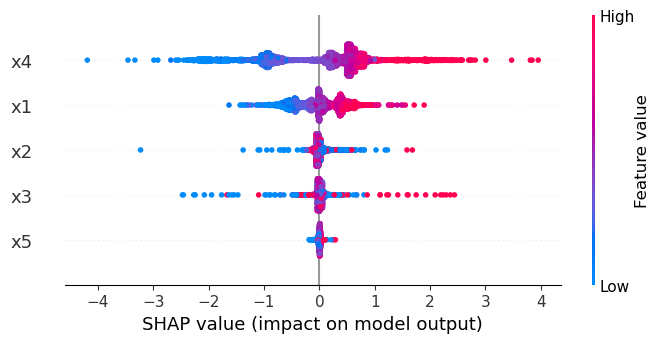

In [147]:
# plot shap values for tot
shap.plots.beeswarm(tot_sv)

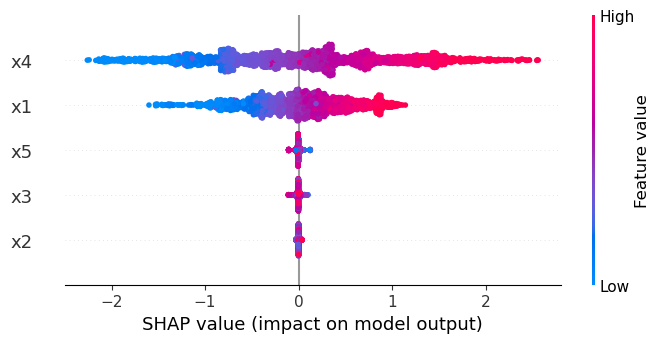

In [148]:
# plot shap values for cf
shap.plots.beeswarm(cf_sv)

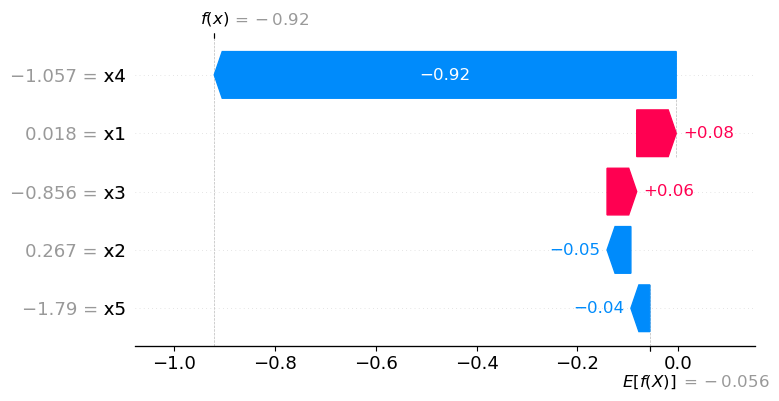

In [164]:
# waterfall plot explain that observation
shap.plots.waterfall(tot_sv[100], max_display=10)

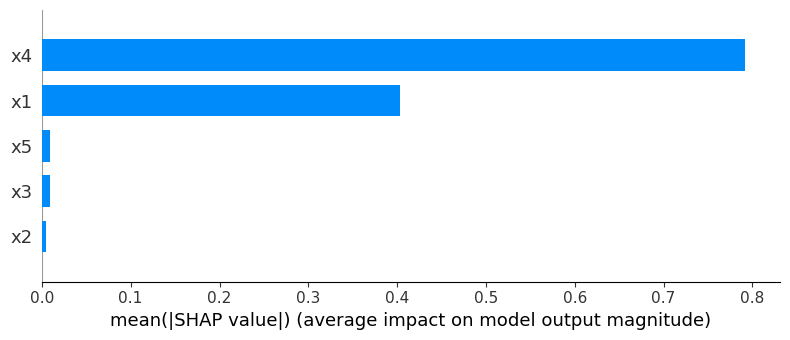

In [149]:
# bar plot
shap.summary_plot(cf_sv, X_train, plot_type="bar")

In [150]:
# explain heterogeneity: cf

cf_tE_het = _tree.TreeExplainer(cf_dml.model_cate.estimators_[0], data=df_train, model_output="squared_loss", feature_dependence="interventional")
cf_sv_het = cf_tE_het(X_train, y = np.array([true_ate]*len(X_train)))

 98%|===================| 2934/3000 [00:13<00:00]        

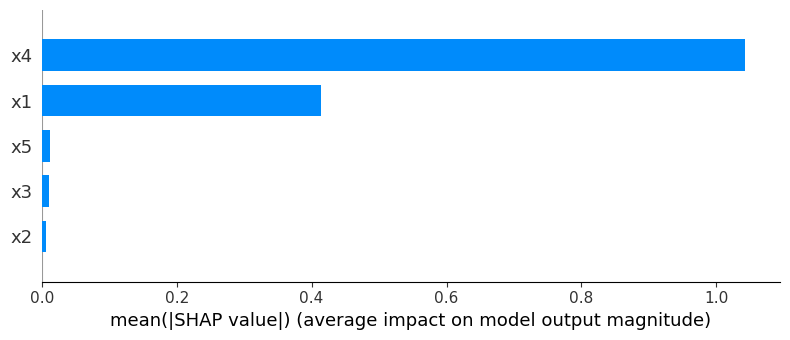

In [151]:
# summary plot
shap.summary_plot(cf_sv_het, X_train, plot_type="bar")

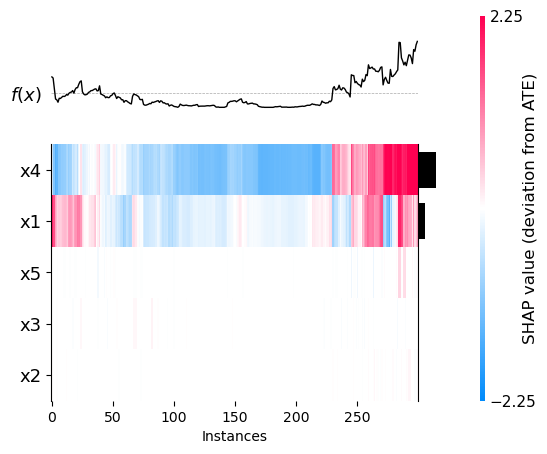

In [154]:
shap.plots.heatmap(cf_sv_het.sample(300), custom_label = "SHAP value (deviation from ATE)")

This approach can be similarly performed on observational data with confounding both in observables, by the use of propensity score adjustments and/or double machine learning techniques (quote Chernozhukov 2016), or even unobservables by the use of IV techniques.\footnote{The corresponding tree objects integrate in the my modified shap code.}

One could also verify the noisiness of the explanation values using an appropriate bootstrap procedure.